# LOBs Encoding 1

This notebook illustrates the LOB encoding with Gaussian Density Filters (GDF).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm

import datetime
import time
import pickle
import gzip

% matplotlib inline

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
import warnings
py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets

from lobs import *
warnings.filterwarnings('ignore')
from lobs import *

In [2]:
filename = "OrderBookSnapshots.csv.9061.zip"
order_book_snapshots = load_order_book_snapshots(filename)
snapshot = order_book_snapshots[131]
date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)

## Limit Order Books

In [3]:
@interact(levels=(1, 100))
def _plot_lob_original(levels=15):
    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price', ytitle='Volume')

interactive(children=(IntSlider(value=15, description='levels', min=1), Output()), _dom_classes=('widget-inter…

## Normalization of Limit Order Books

In [4]:
def normalize_limit_order_book(buy_orders, sell_orders):
    mid_price = (buy_orders[-1, 0] + sell_orders[0, 0]) / 2.0

    if(buy_orders.shape[0] > 0):
        buy_orders[:, 1] = buy_orders[:, 0] * buy_orders[:, 1]
        buy_orders[:, 0] = 1000.0 * (buy_orders[:, 0] - mid_price) / mid_price

    if(sell_orders.shape[0] > 0):
        sell_orders[:, 1] = sell_orders[:, 0] * sell_orders[:, 1]
        sell_orders[:, 0] = 1000.0 * (sell_orders[:, 0] - mid_price) / mid_price

    total_capital = buy_orders[:, 1].sum() + sell_orders[:, 1].sum()
    buy_orders[:, 1] /= total_capital
    sell_orders[:, 1] /= total_capital

    return buy_orders, sell_orders

In [5]:
buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

In [6]:
@interact(levels=(1, 100))
def _plot_lob_normalized(levels=15):
    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price (normalized)', ytitle='Volume (normalized)')

interactive(children=(IntSlider(value=15, description='levels', min=1), Output()), _dom_classes=('widget-inter…

## Encoding Limit Order Books with Gaussian Density Filters

In [7]:
K = 50
gdfs_r = 0.0025 * np.ones(K)
gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
gdfs_s = 0.0500 * np.ones(K)
gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

In [8]:
@interact(levels=(1, 100), gdf=(0, K-1))
def _plot_lob_and_gdf(gdf=K//2+1, levels=20):
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :]))    

interactive(children=(IntSlider(value=26, description='gdf', max=49), IntSlider(value=20, description='levels'…

In [9]:
@interact(levels=(1, 100), gdf=(0, K-1))
def _plot_lob_clipped_to_gdf(gdf=K//2+1, levels=20):
    plot_lob_clipped_to_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :]))

interactive(children=(IntSlider(value=26, description='gdf', max=49), IntSlider(value=20, description='levels'…

In [10]:
gdf_features = np.empty(K)
for k in range(K):
    gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

plot_gdf_features(gdf_features)

## Adjustement of Parameters of Gaussian Density Filters

In [11]:
@interact(r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01))
def _plot_gdf_features(r=0.01, s=0.05):
    K = 50
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(FloatSlider(value=0.01, description='r', max=1.0, min=0.01, step=0.01), FloatSlider(valu…

## Observing Limit Order Books in Time

In [12]:
N = len(order_book_snapshots)
@interact(t=(0, N-1), levels=(1, 100))
def _plot_lob_original(t=131, levels=15):
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)

    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price', ytitle='Volume')

interactive(children=(IntSlider(value=131, description='t', max=5473), IntSlider(value=15, description='levels…

In [13]:
@interact(t=(0, N-1), levels=(1, 100))
def _plot_lob_normalized(t=131, levels=15):
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price (normalized)', ytitle='Volume (normalized)')

interactive(children=(IntSlider(value=131, description='t', max=5473), IntSlider(value=15, description='levels…

In [14]:
K = 50
gdfs_r = 0.0025 * np.ones(K)
gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
gdfs_s = 0.0500 * np.ones(K)
gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

In [15]:
@interact(t=(0, N-1))
def _plot_gdf_features(t=131):
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(IntSlider(value=131, description='t', max=5473), Output()), _dom_classes=('widget-intera…

In [16]:
@interact(r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1))
def _plot_gdf_features(r=0.01, s=0.05, t=131):
    K = 50
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(FloatSlider(value=0.01, description='r', max=1.0, min=0.01, step=0.01), FloatSlider(valu…

In [29]:
@interact(levels=(1, 100),  r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1), gdf=(0, K-1))
def _plot_lob_and_gdf(levels=20, r=0.01, s=0.05, t=131, gdf=K//2+1):
    K = 51
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :]))  

interactive(children=(IntSlider(value=20, description='levels', min=1), FloatSlider(value=0.01, description='r…

In [18]:
@interact(levels=(1, 100),  r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1), K=(1, 50))
def _plot_lob_and_gdf(levels=20, r=0.01, s=0.05, t=131, K=15):
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    gdf = 1
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :])) 

interactive(children=(IntSlider(value=20, description='levels', min=1), FloatSlider(value=0.01, description='r…

In [19]:
@interact(r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1), K=(1, 50))
def _plot_gdf_features(r=0.01, s=0.05, t=131, K=15):
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(FloatSlider(value=0.01, description='r', max=1.0, min=0.01, step=0.01), FloatSlider(valu…

## Random plots

In [20]:
sn = order_book_snapshots[1733]
dt, bo, so = transform_order_book_snapshot_to_orders(sn)
print(dt)
bo, so = normalize_limit_order_book(bo, so)

b = [{'price': b[0], 'volume': b[1]} for b in bo]
df_b = pd.DataFrame(b)
df_b

2013-09-05 09:26:00


,price,volume
0,-257.892870,0.000442
1,-219.581412,0.002955
2,-127.350124,0.001887
3,-106.065981,0.008035
4,-104.647038,0.000978
5,-103.228095,0.001267
6,-98.971266,0.008149
7,-93.295495,0.001349
8,-91.876552,0.004701
9,-89.038666,0.004336


In [21]:
K = 50
gdfs_r = 0.0025 * np.ones(K)
gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
gdfs_s = 0.0500 * np.ones(K)
gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

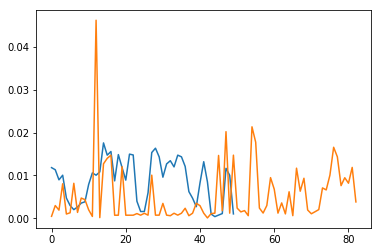

In [22]:
plt.plot([gdf_representation(bo, so, gdfs[k, :]) for k in range(0, K)])
plt.plot(df_b[[ 'volume']])

In [23]:
gdf_representation(bo, so, gdfs[0, :])

0.011803799371167123

In [24]:
dt

datetime.datetime(2013, 9, 5, 9, 26)

In [25]:
buy_orders

array([[-2.03418061e+02,  3.16358218e-03],
       [-8.75515968e+01,  8.55029441e-03],
       [-8.61032660e+01,  1.04481906e-03],
       [-8.46549352e+01,  1.35607607e-03],
       [-8.03099428e+01,  8.72375727e-03],
       [-7.45166196e+01,  1.44386679e-03],
       [-7.30682888e+01,  4.62760435e-03],
       [-7.01716272e+01,  4.64206562e-03],
       [-6.58266348e+01,  1.74890907e-03],
       [-5.85849808e+01,  4.02764720e-02],
       [-5.69918169e+01,  8.82724569e-04],
       [-5.40951553e+01,  8.85436056e-04],
       [-5.11984937e+01,  8.88147543e-04],
       [-4.83018321e+01,  8.90859030e-04],
       [-4.54051705e+01,  8.93570517e-04],
       [-4.41016728e+01,  7.22215389e-03],
       [-4.36671736e+01,  9.11310962e-04],
       [-4.25085089e+01,  8.96282004e-04],
       [-4.17843435e+01,  1.19594650e-03],
       [-4.12050112e+01,  1.49583695e-02],
       [-3.96118473e+01,  8.98993490e-04],
       [-3.68600188e+01,  1.57474122e-02],
       [-3.67151857e+01,  9.01704977e-04],
       [-3.

In [26]:
@interact(levels=(1, 100),  r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), m=(0.001, 1.00, 0.01), t=(0, N-1), K=(1, 50))
def _plot_lob_and_gdf(levels=20, r=0.01, s=0.05, m=0.1, t=131, K=15):
    gdfs_r = r * np.ones(K)
    gdfs_m = m * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    gdf = 1
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :])) 

interactive(children=(IntSlider(value=20, description='levels', min=1), FloatSlider(value=0.01, description='r…